In [ ]:
import os
#import shutil
!pip3 install dgl
import json
!pip3 install sacred
from sacred import Experiment
from sacred.config import config_scope
#import yaml
import torch
import torch.backends.cudnn as cudnn
import math
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path

from sacred import SETTINGS
SETTINGS.CONFIG.READ_ONLY_CONFIG = False

On importe le code depuis un Google drive. Pour modifier les paramètres du réseau qui va être entrainé, il faut modifier le fichier default_config dans ce drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/ColabNotebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Modifier le chemin d'accès en fonction de l'architecture du drive :

In [ ]:
cd drive/MyDrive/'projet MAP583'/'code'

/content/drive/MyDrive/projet MAP583/code


In [ ]:
from models import get_model, get_model_gen
from toolbox.losses import triplet_loss
from toolbox import metrics
from loaders.data_generator import QAP_Generator
from loaders.siamese_loaders import siamese_loader
from toolbox.metrics import all_losses_acc, accuracy_linear_assignment
from toolbox.utils import check_dir

Using backend: pytorch


La cellule ci-dessous vise à provoquer une erreur dans le code .yaml, précisant que l'attribut .FullLoader n'existe pas. Il suffit de modifier le fichier en question en remplaçant .FullLoader par .Loader et  de redémarer l'environnement d'exécution pour le faire fonctionner.

In [ ]:
ex = Experiment(save_git_info=False, name ='current', interactive = True)
ex.add_config('default_config.yaml')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!python commander.py train

Using backend: pytorch
WARNING - commander - No observers have been added to this run
INFO - commander - Running command 'train'
INFO - commander - Started
Heading to Training.
Current problem :  qap
Using device: cuda
Models saved in  /root/experiments-gnn/qap/qap_res/fgnn_2_ErdosRenyi_50_0.0015/03-07-22-07-54
Creating dataset at /root/experiments-gnn/qap/data/QAP_ErdosRenyi_ErdosRenyi_200_50_1.0_0.1_0.0015/train.pkl
100% 200/200 [00:01<00:00, 190.51it/s]
Saving dataset at /root/experiments-gnn/qap/data/QAP_ErdosRenyi_ErdosRenyi_200_50_1.0_0.1_0.0015/train.pkl
Creating dataset at /root/experiments-gnn/qap/data/QAP_ErdosRenyi_ErdosRenyi_200_50_1.0_0.1_0.0015/train_dgl.pkl
Converting data to DGL format
100% 200/200 [00:00<00:00, 445.06it/s]
Conversion ended.
Saving dataset at /root/experiments-gnn/qap/data/QAP_ErdosRenyi_ErdosRenyi_200_50_1.0_0.1_0.0015/train_dgl.pkl
Creating dataset at /root/experiments-gnn/qap/data/QAP_ErdosRenyi_ErdosRenyi_10_50_1.0_0.1_0.0015/val.pkl
100% 10/10 [00:

In [ ]:
def get_device_config(model_path):
    config_file = os.path.join(model_path,'config.json')
    logger_file = os.path.join(model_path,'logger.json')
    with open(config_file) as json_file:
        config_model = json.load(json_file)
    with open(logger_file) as json_file:
        logger_model = json.load(json_file)
    use_cuda = not config_model['cpu'] and torch.cuda.is_available()
    device = 'cuda' if use_cuda else 'cpu'
    return config_model, device, logger_model

def load_model(model_path, config, device):
    model = get_model_gen(config['arch'])
    model.to(device)
    model_file = os.path.join(model_path,'model_best.pth.tar')
    if device == 'cpu':
        checkpoint = torch.load(model_file,map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(model_file)
    model.load_state_dict(checkpoint['state_dict'])
    return model

def creat_args(config, num_ex = 1000):
    args = config
    print(args)
    args['num_examples_test'] = num_ex
    n_vertices = args['n_vertices']
    edge_density = args['edge_density']
    deg = (n_vertices)*edge_density
    print(f'graphs with {n_vertices} vertices and average degree {deg}')
    return args, deg

def acc_2_error(mean_acc, q_acc):
    error = q_acc-mean_acc[:,np.newaxis]
    error[:,0] = -error[:,0]
    return error

def compute_all(list_noise,args,path_dataset,model,bs=50):
    num_batches = math.ceil(args['num_examples_test']/bs)
    all_losses = np.zeros((len(list_noise),num_batches))
    all_acc = np.zeros((len(list_noise),args['num_examples_test']))
    for i,noise in enumerate(list_noise):
        args['noise'] = noise
        gene_test = QAP_Generator('test', args, path_dataset)
        gene_test.load_dataset()
        test_loader = siamese_loader(gene_test, bs, gene_test.constant_n_vertices)
        all_losses[i,:], all_acc[i,:] = all_losses_acc(test_loader,model,criterion,device,eval_score=accuracy_linear_assignment)
    return all_losses, all_acc

def compute_quant(all_acc,quant_low=0.1,quant_up=0.9):
    mean_acc = np.mean(all_acc,1)
    num = len(mean_acc)
    q_acc = np.zeros((num,2))
    for i in range(num):
        q_acc[i,:] = np.quantile(all_acc[i,:],[quant_up, quant_low])
    return mean_acc, q_acc

In [ ]:
cd

/root


In [ ]:
model_path = '/root/experiments-gnn/qap/qap_res/fgnn_2_ErdosRenyi_50_0.0015/03-07-22-07-54' # modifier le chemin en fonction de celui afficher dans la boucle train
config_model, device, logger_model = get_device_config(model_path)
model = load_model(model_path,config_model,device)
criterion = triplet_loss()

args,deg  = creat_args(logger_model['options']['data']['test'])

num = 23
list_noise = np.linspace(0, 0.22, num=num)

Fetching model fgnn siamese - (rs_node  embedding if fgnn)
{'num_examples_test': 10, 'n_vertices': 50, 'sparsify': 'None', 'generative_model': 'ErdosRenyi', 'noise_model': 'ErdosRenyi', 'edge_density': 0.0015, 'vertex_proba': 1.0, 'noise': 0.1}
graphs with 50 vertices and average degree 0.075


In [ ]:
for p in model.parameters():
    p.requires_grad = False

In [ ]:
ROOT_DIR = Path.home()
path_dataset = os.path.join(ROOT_DIR, 'data/')
all_l, all_a = compute_all(list_noise,args,path_dataset,model);

Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.0_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 420.42it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.0_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.0_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 811.17it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.0_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.01_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 469.80it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.01_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.01_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 891.14it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.01_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.02_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 477.40it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.02_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.02_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 844.05it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.02_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.03_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 466.69it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.03_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.03_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 814.95it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.03_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.04_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 452.22it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.04_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.04_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 898.87it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.04_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.05_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 451.87it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.05_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.05_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 828.02it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.05_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.06_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 435.97it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.06_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.06_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 902.34it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.06_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.07_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 445.21it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.07_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.07_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 878.30it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.07_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.08_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 437.80it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.08_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.08_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 827.41it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.08_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.09_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 428.11it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.09_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.09_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 888.42it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.09_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.1_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 421.93it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.1_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.1_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 812.63it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.1_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.11_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 399.14it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.11_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.11_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 883.19it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.11_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.12_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 416.51it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.12_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.12_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 830.81it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.12_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.13_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 395.57it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.13_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.13_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 851.57it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.13_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.14_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 401.60it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.14_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.14_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 818.58it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.14_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.15_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 400.54it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.15_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.15_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 917.84it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.15_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.16_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 388.15it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.16_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.16_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 818.00it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.16_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.17_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 391.96it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.17_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.17_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 827.91it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.17_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.18_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 380.41it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.18_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.18_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 817.34it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.18_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.19_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 367.38it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.19_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.19_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 865.40it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.19_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.2_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 371.02it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.2_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.2_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 806.57it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.2_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.21_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 370.92it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.21_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.21_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 818.91it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.21_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.22_0.0015/test.pkl


100%|██████████| 1000/1000 [00:02<00:00, 368.57it/s]


Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.22_0.0015/test.pkl
Creating dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.22_0.0015/test_dgl.pkl
Converting data to DGL format


100%|██████████| 1000/1000 [00:01<00:00, 833.01it/s]


Conversion ended.
Saving dataset at /root/data/QAP_ErdosRenyi_ErdosRenyi_1000_50_1.0_0.22_0.0015/test_dgl.pkl


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
quant_low=0.1
quant_up=0.9
mc_50, q50 = compute_quant(all_a,quant_low=quant_low,quant_up=quant_up)

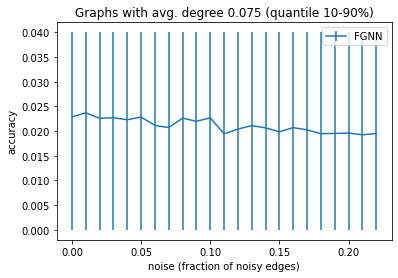

In [ ]:
error_50 = acc_2_error(mc_50,q50)

plt.errorbar(list_noise,mc_50,yerr=error_50.T,label='FGNN');
plt.xlabel('noise (fraction of noisy edges)')
plt.ylabel('accuracy')
plt.title(f'Graphs with avg. degree {deg} (quantile {int(100*quant_low)}-{int(100*quant_up)}%)')
plt.legend()
plt.show()